In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import warnings

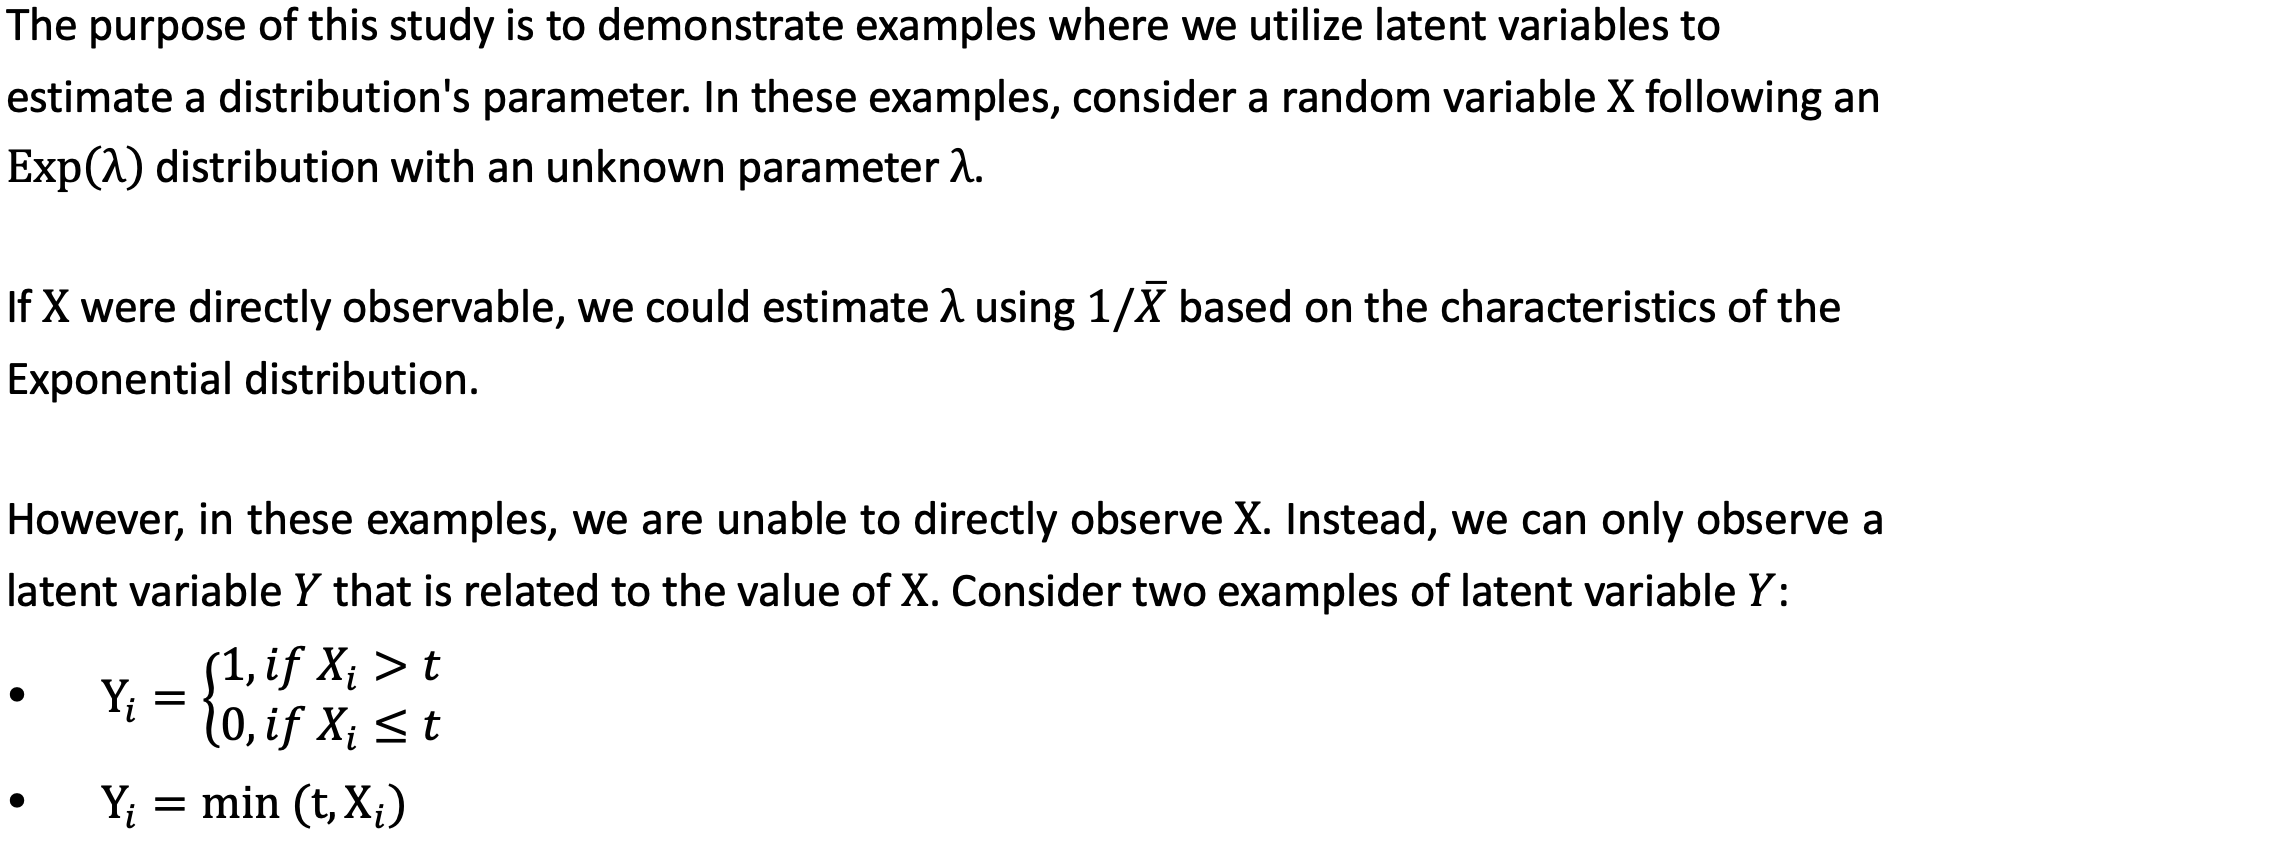

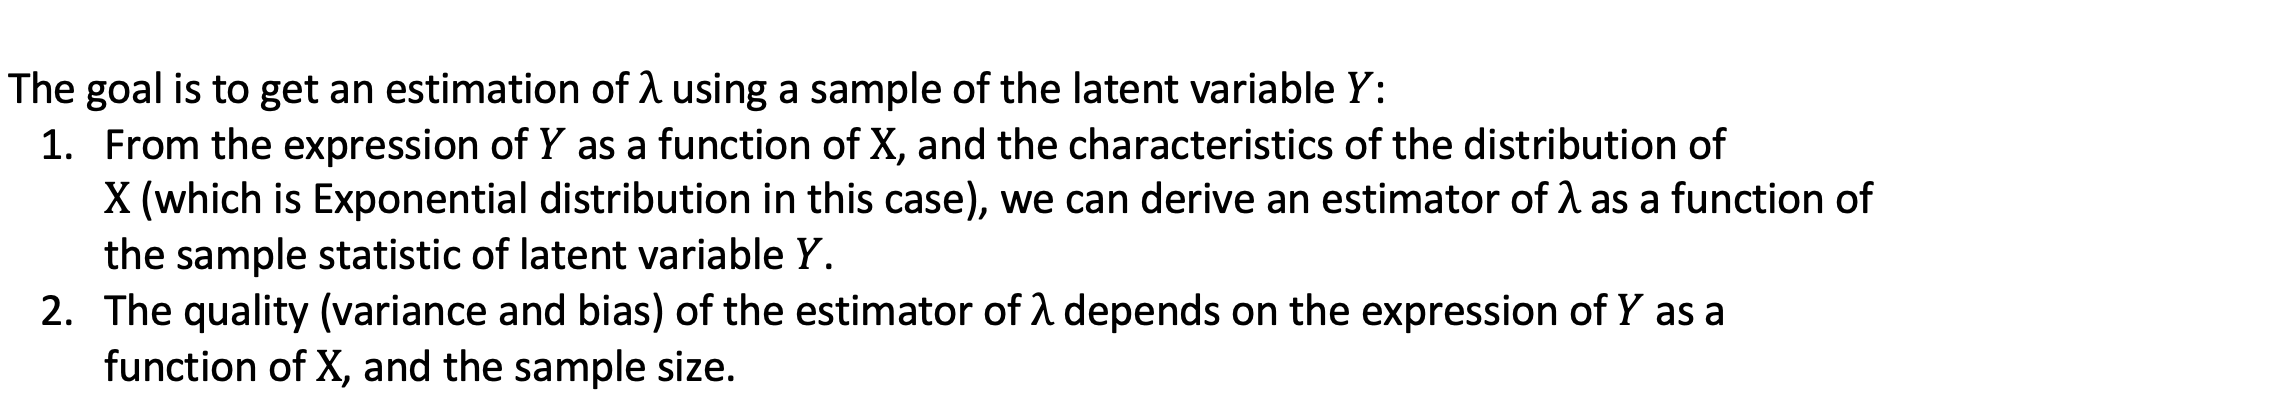

### More information about [latent variable](https://en.wikipedia.org/wiki/Latent_and_observable_variables)

# Using Latent Variable to estimate Lambda: Example 1
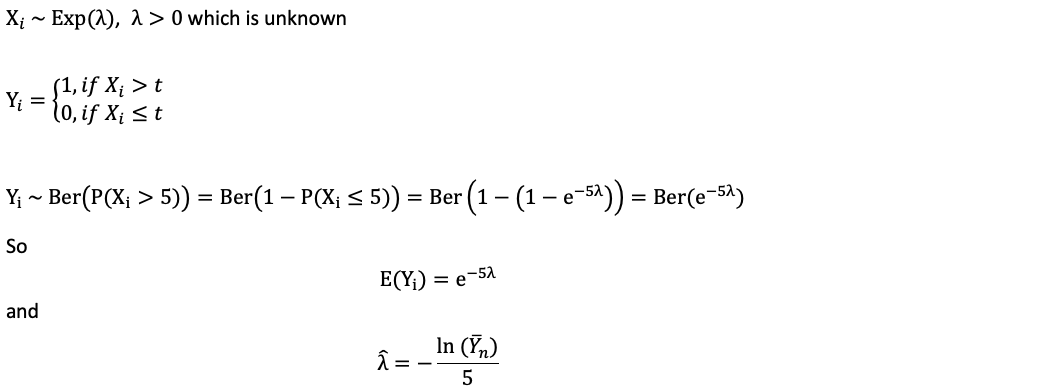

### First, we simulate the 1000 observations based on the information above. 

sample mean of y: 0.948, Known
theotical mean of y: 0.951, UnKnown


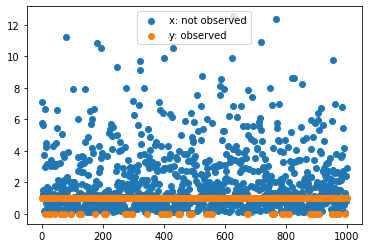

In [2]:
N = 1000
def censored_exp_plot(Lambda,threshold):
    ##### Lambda the the lambda appears in Exp(lambda) expression, in wiki
    ##### In np.random.exponential, the parameter is scale, i.e. inverse Lambda
    x_data = list(np.random.exponential(scale = 1/Lambda,size= N))
    y_data = [int(x_data[i]>threshold) for i in range(len(x_data))]
    print('sample mean of y: '+str(round(np.mean(y_data),3))+', Known')
    print('theotical mean of y: '+str(round(np.exp((-1)*(threshold)*Lambda),3))+', UnKnown')
    plt_range = list(range(1,len(x_data)+1))
    plt.scatter(plt_range,x_data,label='x: not observed')
    plt.scatter(plt_range,y_data,label='y: observed')
    plt.legend()
    plt.show()

censored_exp_plot(Lambda=0.5,threshold=0.1)    

In [3]:
##### Use a random created value or a specified value for Lambda_true. 
##### Here we set Lambda_true = 0.6
##### Note that this is treated as unknown, i.e, the estimator will not use this information. 

#Lambda_true  = float(np.random.uniform(0,1,1))
Lambda_true   = 0.6
print(Lambda_true)   
N_Population  = 1000000
x_population  = list(np.random.exponential(scale = 1/Lambda_true,size= N_Population))

0.6


### Two functions will be used:

#### estimate_Lambda(sample_size,threshold): 

This function returns two estimates for Lambda. Subsequently, we will compare these two estimators.
1. The first one is Lambda_est_x, representing the estimate we would obtain if we could observe observations for all X. The expression for this estimator is derived based on the characteristics of the Exponential distribution. 
2. The second one is Lambda_est_y, representing the estimate we would obtain if we cannot observe observations for X and only have access to y. The derivation of the expression for this estimator is explained above. 

Regarding the two parameters in the function: both estimators require the a sample data, either of x or y, with "sample_size" specifying the size of the sample. The expression for Lambda_est_y include the "threshold". 

Note that this function is a one-time estimation. We will do a lot of experiemmt in the function "experiment".  

#### experiment(n_experiment,sample_size,threshold)
This function can perform multiple estimation experiments for Lambda using the given sample size and threshold. In each experiment, we can obtain two estimators, one based on observations of X and the other based on observations of Y. From the results, we can observe the impact of these two variables on the distribution of estimators. 

The returned result includes the estimates obtained across all experiments, along with a density histogram that visualizes these estimates. Additionally, the mean and variance of these estimates are calculated. 

Note that that actual value of Lambda is also presented in the histogram plot. It is unknow during the estimation, but can be considered for evaluating of the estimates. 

In [4]:
def estimate_Lambda(sample_size,threshold):
    x_sample = np.random.choice(x_population,size=sample_size,replace=True)
    y_sample = [int(x_sample[i]>threshold) for i in range(sample_size)]
    Lambda_est_x = 1/np.mean(x_sample)
    Lambda_est_y = -np.log(np.mean(y_sample))/threshold
    return Lambda_est_x,Lambda_est_y

def experiment(n_experiment,sample_size,threshold):
    result = pd.DataFrame({'sample_id':range(1,n_experiment+1)})
    colnamex = 'using_x_sample_size'+str(sample_size)
    colnamey = 'using_y_sample_size'+str(sample_size)
    result[colnamex]=np.nan*n_experiment
    result[colnamey]=np.nan*n_experiment
    for e in range(n_experiment):
        x,y = estimate_Lambda(sample_size,threshold)
        result.loc[e,colnamex] = x
        result.loc[e,colnamey] = y
    result.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    labelx = 'x_est:mean='+str(round(result[colnamex].mean(),3))+'; var='+str(round(result[colnamex].var(),2))
    labely = 'y_est:mean='+str(round(result[colnamey].mean(),3))+'; var='+str(round(result[colnamey].var(),2))
    
    num_y_est_na = result[colnamey].isna().sum()
    if num_y_est_na>0:
        labely = labely+'; NA:'+str(num_y_est_na)+'/'+str(n_experiment)
    
    plt.hist(result[colnamex],bins=20,density=False,alpha=0.6,label=labelx)
    plt.hist(result[colnamey],bins=20,density=False,alpha=0.6,label=labely)
    plt.axvline(x=Lambda_true, color='r',label='True:'+str(round(Lambda_true,3)))
    plt.legend()
    plt.title('Sample Size: '+ str(sample_size) +', Threshold:' + str(threshold))
    plt.show()
    return result

In [5]:
## The root cause of the warnings is that in some experiments the there is no x > the threshold. 
## So the estimation is not available - will use log(0). 
## for each experiment, the probability of unavailable y_est is [P(x_i<threshold)]^sample_size
warnings.filterwarnings("ignore")

### The results show
### 1. In general, x_est has smaller variance. But the bias of x_est is not significanlt smaller than that of x_est (unless the threshold is too high leading to unavailable y_est in many experiments).
### 2. As mentioned above, when the threshold value is too high, such as 5, in many experiments, there is no single x great then this threshold in the sample, so the mean of Y is 0, leading to a calculation error in the expression of the Lambda estimator.
### 3. Note that the true Lambda is unknown, so in reality we cannot calculate the bias of an estimator, and use that to evaluate the estimators with different thresholds. The good news is that if the sample size is large enough, such as 100, the y_est using different thresholds are pretty close.
### 4. Takeaways: (1) when the sample size is large enough, the y_est, estimator based on the observations of latent variables are generally reliable, and not sensitive to the choice of threshold (unless it is extremely high). For small sample size, the choice of threshold is more important, but one can try different threshold values and get a first round estimation of Lambda, then use this information to adjust the value of threshold and get updated estimate.

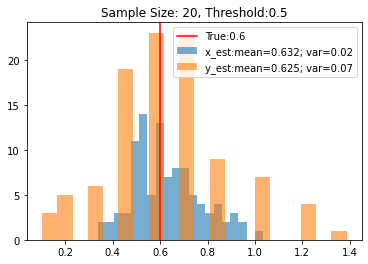

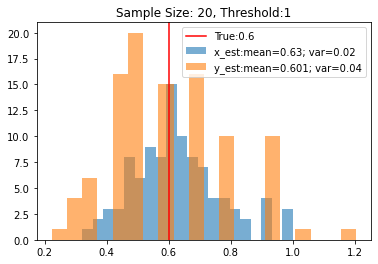

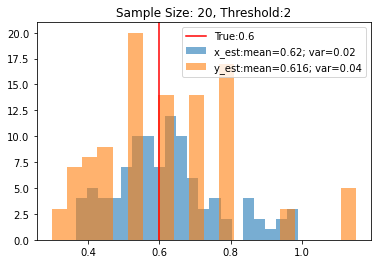

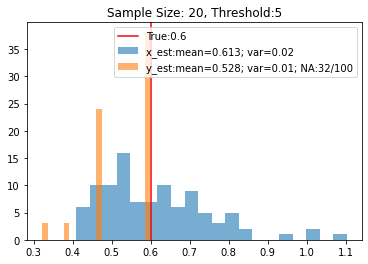

In [6]:
N_Experiment = 100
Sample_Size  = 20
a=experiment(n_experiment=N_Experiment,sample_size=Sample_Size,threshold=0.5)
a=experiment(n_experiment=N_Experiment,sample_size=Sample_Size,threshold=1)
a=experiment(n_experiment=N_Experiment,sample_size=Sample_Size,threshold=2)
a=experiment(n_experiment=N_Experiment,sample_size=Sample_Size,threshold=5)

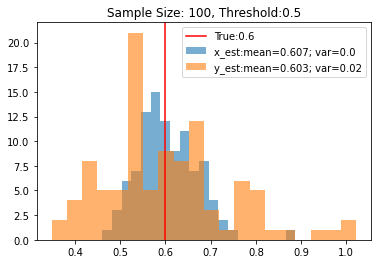

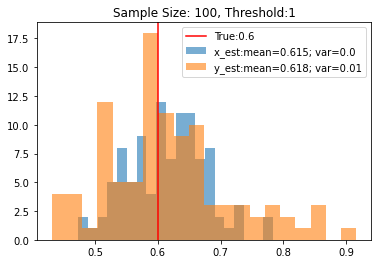

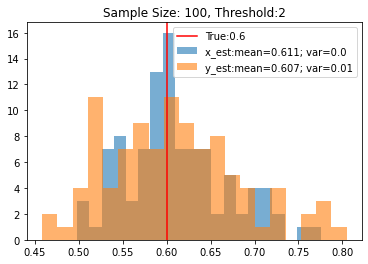

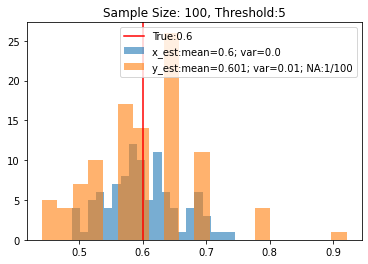

In [7]:
N_Experiment = 100
Sample_Size  = 100
a=experiment(n_experiment=N_Experiment,sample_size=Sample_Size,threshold=0.5)
a=experiment(n_experiment=N_Experiment,sample_size=Sample_Size,threshold=1)
a=experiment(n_experiment=N_Experiment,sample_size=Sample_Size,threshold=2)
a=experiment(n_experiment=N_Experiment,sample_size=Sample_Size,threshold=5)

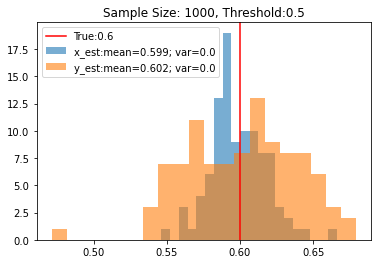

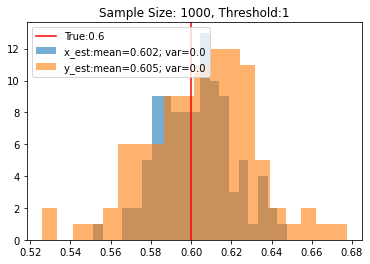

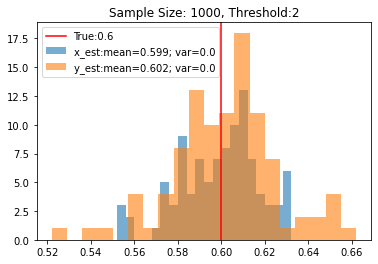

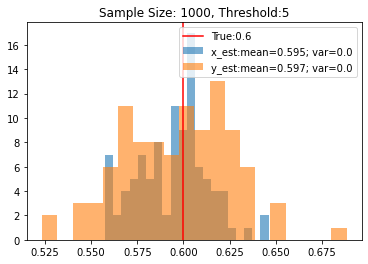

In [8]:
N_Experiment = 100
Sample_Size  = 1000
a=experiment(n_experiment=N_Experiment,sample_size=Sample_Size,threshold=0.5)
a=experiment(n_experiment=N_Experiment,sample_size=Sample_Size,threshold=1)
a=experiment(n_experiment=N_Experiment,sample_size=Sample_Size,threshold=2)
a=experiment(n_experiment=N_Experiment,sample_size=Sample_Size,threshold=5)

# Using Latent Variable to estimate Lambda: Example 2
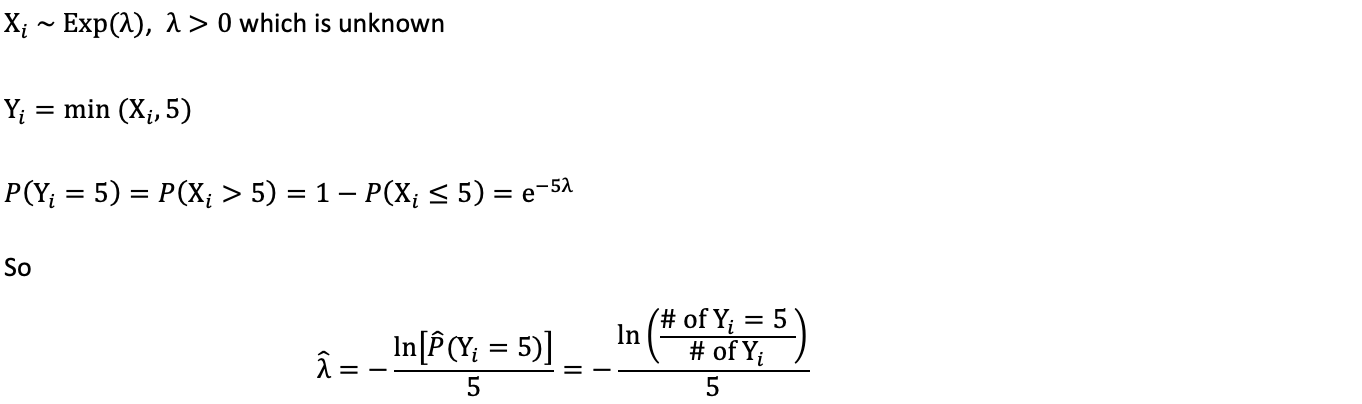

sample P(y=20): 0.01, Known
theotical P(y=20): 0.018, UnKnown


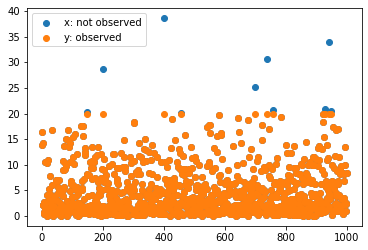

Note that given Yi=min(Xi,threshold),every orange point below the threshold overlaps with a blue point (not shown)


In [10]:
N = 1000
def censored_exp_plot(Lambda,threshold):
    ##### Lambda the the lambda appears in Exp(lambda) expression, in wiki
    ##### In np.random.exponential, the parameter is scale, i.e. inverse Lambda
    x_data = list(np.random.exponential(scale = 1/Lambda,size= N))
    y_data = [min(threshold,x_data[i]) for i in range(len(x_data))]
    check  = [int(y_data[i]==threshold) for i in range(len(x_data))]
    print('sample P(y='+str(threshold)+'): '+str(round(np.mean(check),3))+', Known')
    print('theotical P(y='+str(threshold)+'): '+str(round(np.exp(-1*(threshold)*Lambda),3))+', UnKnown')
    plt_range = list(range(1,len(x_data)+1))
    plt.scatter(plt_range,x_data,label='x: not observed')
    plt.scatter(plt_range,y_data,label='y: observed')
    plt.legend()
    plt.show()

censored_exp_plot(Lambda=0.2,threshold=20)  
print("Note that given Yi=min(Xi,threshold),every orange point below the threshold overlaps with a blue point (not shown)")

In [11]:
Lambda_true     = float(np.random.uniform(0,1,1))
Lambda_true     = 0.6
print(Lambda_true)   
N_Population    = 1000000
x_population    = list(np.random.exponential(scale = 1/Lambda_true,size= N_Population))

0.6


In [12]:
def estimate_Lambda(sample_size,threshold):
    x_sample = np.random.choice(x_population,size=sample_size,replace=True)
    y_sample = [min(threshold,x_sample[i]) for i in range(sample_size)]
    check    = [int(y_sample[i]==threshold) for i in range(sample_size)]
    Lambda_est_x = 1/np.mean(x_sample)
    Lambda_est_y = -np.log(np.mean(check))/threshold
    return Lambda_est_x,Lambda_est_y

def experiment(n_experiment,sample_size,threshold):
    result = pd.DataFrame({'sample_id':range(1,n_experiment+1)})
    colnamex = 'using_x_sample_size'+str(sample_size)
    colnamey = 'using_y_sample_size'+str(sample_size)
    result[colnamex]=np.nan*n_experiment
    result[colnamey]=np.nan*n_experiment
    for e in range(n_experiment):
        x,y = estimate_Lambda(sample_size,threshold)
        result.loc[e,colnamex] = x
        result.loc[e,colnamey] = y
    result.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    labelx = 'x_est:mean='+str(round(result[colnamex].mean(),3))+'; var='+str(round(result[colnamex].var(),2))
    labely = 'y_est:mean='+str(round(result[colnamey].mean(),3))+'; var='+str(round(result[colnamey].var(),2))
    
    num_y_est_na = result[colnamey].isna().sum()
    if num_y_est_na>0:
        labely = labely+'; NA:'+str(num_y_est_na)+'/'+str(n_experiment)
    
    plt.hist(result[colnamex],bins=20,density=False,alpha=0.6,label=labelx)
    plt.hist(result[colnamey],bins=20,density=False,alpha=0.6,label=labely)
    plt.axvline(x=Lambda_true, color='r',label='True:'+str(round(Lambda_true,3)))
    plt.legend()
    plt.title('Sample Size: '+ str(sample_size) +', Threshold:' + str(threshold))
    plt.show()
    return result

In [13]:
## The root cause of the warnings is that in some experiments the there is no x > the threshold. 
## So the estimation is not available - will use log(0). 
## for each experiment, the probability of unavailable y_est is [P(x_i<threshold)]^sample_size
warnings.filterwarnings("ignore")

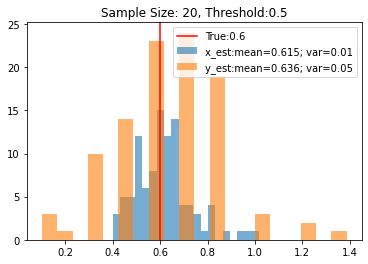

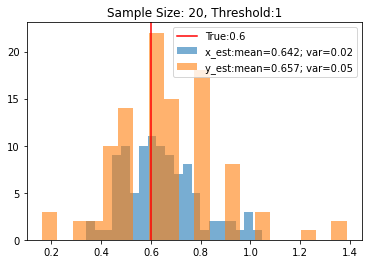

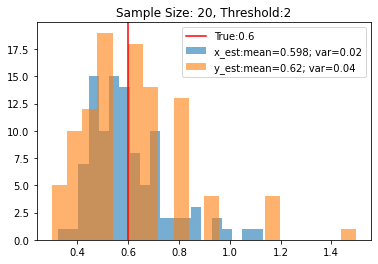

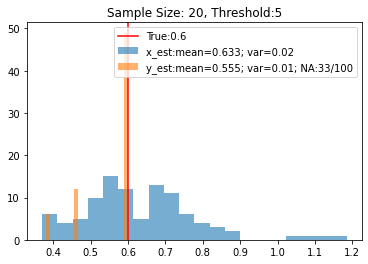

In [14]:
N_Experiment = 100
Sample_Size  = 20
a=experiment(n_experiment=N_Experiment,sample_size=Sample_Size,threshold=0.5)
a=experiment(n_experiment=N_Experiment,sample_size=Sample_Size,threshold=1)
a=experiment(n_experiment=N_Experiment,sample_size=Sample_Size,threshold=2)
a=experiment(n_experiment=N_Experiment,sample_size=Sample_Size,threshold=5)

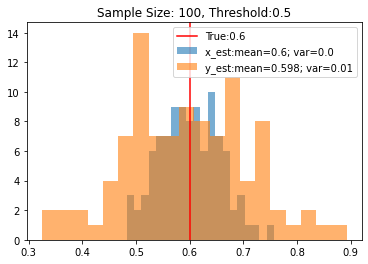

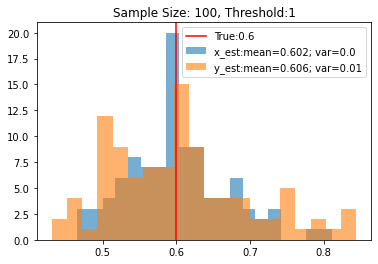

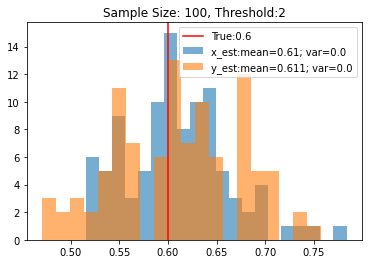

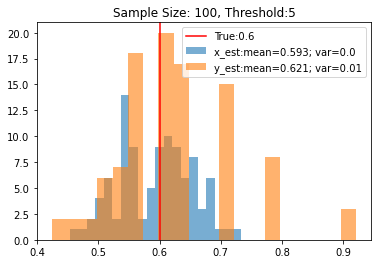

In [15]:
N_Experiment = 100
Sample_Size  = 100
a=experiment(n_experiment=N_Experiment,sample_size=Sample_Size,threshold=0.5)
a=experiment(n_experiment=N_Experiment,sample_size=Sample_Size,threshold=1)
a=experiment(n_experiment=N_Experiment,sample_size=Sample_Size,threshold=2)
a=experiment(n_experiment=N_Experiment,sample_size=Sample_Size,threshold=5)

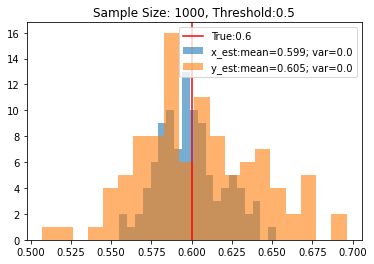

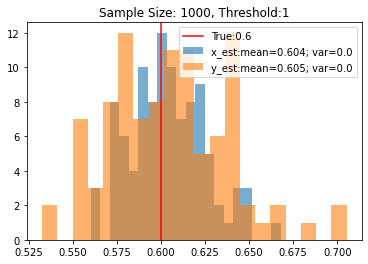

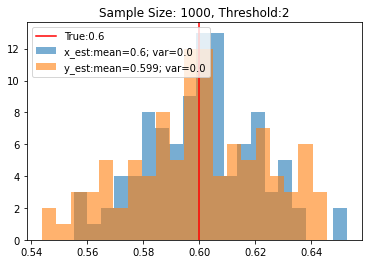

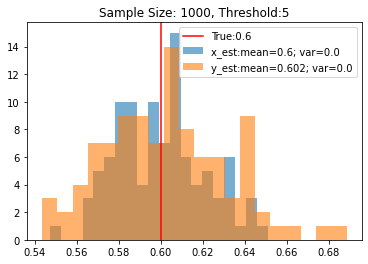

In [16]:
N_Experiment = 100
Sample_Size  = 1000
a=experiment(n_experiment=N_Experiment,sample_size=Sample_Size,threshold=0.5)
a=experiment(n_experiment=N_Experiment,sample_size=Sample_Size,threshold=1)
a=experiment(n_experiment=N_Experiment,sample_size=Sample_Size,threshold=2)
a=experiment(n_experiment=N_Experiment,sample_size=Sample_Size,threshold=5)